In [1]:
%load_ext autoreload
%autoreload 2

import logging

logging.basicConfig(level=logging.WARNING)
logging.getLogger('anonymigraph').setLevel(logging.WARNING)
logging.getLogger('anonymigraph.metrics').setLevel(logging.WARNING)


In [2]:
from anonymigraph.metrics.evaluator import Evaluator
from anonymigraph.metrics.utility.structural.privacy_metrics import PercentageKDegreeAnonMetric

from anonymigraph.metrics.utility.structural import (
    DegreeCentralityMetric,
    EigenvectorMetric,
    PageRankMetric,
    ClosenessCentralityMetric,
    LocalClusteringCoefficientMetric,
    WLColorMetric,

    ConnectedComponentsMetric,
    NumberOfEdgesMetric,
    NumberOfNodesMetric,
    NumberOfTrianglesMetric,
    MeanDegreeMetric,
    MaxDegreeMetric,
    MedianDegreeMetric,
    AverageClusteringCoefficientMetric,
    TransitivityMetric,

    EdgeJaccardMetric,
    KatzCentralityMetric,

)

from anonymigraph.anonymization import (
    KDegreeAnonymizer,
    RandomEdgeAddDelAnonymizer,
    ConfigurationModelAnonymizer,
    NestModelAnonymizer,
    PygmalionModelAnonymizer,
    PrivateColorAnonymizer,
)


# Polbooks

In [3]:
import networkx as nx
from scipy.sparse.linalg import eigs
import numpy as np
import os
import urllib.request
import pickle

if not os.path.exists('polbooks.gml'):
    urllib.request.urlretrieve('https://networkdata.ics.uci.edu/data/polbooks/polbooks.gml', 'polbooks.gml')

G = nx.read_gml('polbooks.gml')
G = nx.convert_node_labels_to_integers(G)

eigenvalues, _ = eigs(nx.adjacency_matrix(G).astype(np.float64), k=1, which='LM')
max_alpha = 1 / np.abs(eigenvalues).max()

alpha=0.5*max_alpha
beta=1
print(G)
print("Alpha:", alpha)

Graph with 105 nodes and 441 edges
Alpha: 0.04190189608200814


In [4]:
polbooks_samples_data = []
for seed in range(42, 42+4): # 4 samples with different seeds
    # METRICS
    metrics = {
        # Important
        # Graph Level
        #"|Δ|": NumberOfTrianglesMetric(),
        #"Transitivity": TransitivityMetric(),

        # Node Level
        "Katz": KatzCentralityMetric(alpha=alpha),
        "Ev.": EigenvectorMetric(),
        "LCC": LocalClusteringCoefficientMetric(),
        #"TVD WL Colors d=2": WLColorMetric(depth=2),

        # Graph Level
        #"|CC|": ConnectedComponentsMetric(),
        #"Median Deg.": MedianDegreeMetric(),
        #"Avg. Deg.": MeanDegreeMetric(),
        #"Max Deg.": MaxDegreeMetric(),
        #"PageRank":	PageRankMetric(),

        "EJacc": EdgeJaccardMetric(),
    }

    methods = {}

    #methods["PrivateColor(w=1e1)"] = PrivateColorAnonymizer(w=1e1, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-0}"] = PrivateColorAnonymizer(w=1e-0, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-1}"] = PrivateColorAnonymizer(w=1e-1, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-2}"] = PrivateColorAnonymizer(w=1e-2, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 5 10^{-3}"] = PrivateColorAnonymizer(w=5e-3, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-3}"] = PrivateColorAnonymizer(w=1e-3, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 7.5 10^{-4}"] = PrivateColorAnonymizer(w=7.5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 5 10^{-4}"] = PrivateColorAnonymizer(w=5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 4 10^{-4}"] = PrivateColorAnonymizer(w=4e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 2.5 10^{-4}"] = PrivateColorAnonymizer(w=2.5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-4}"] = PrivateColorAnonymizer(w=1e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 5 10^{-5}"] = PrivateColorAnonymizer(w=5e-5, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 4 10^{-5}"] = PrivateColorAnonymizer(w=1e-5, alpha=alpha, is_eager=True, use_optimal1d=False)

    methods[r"80 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(80/100*G.number_of_edges()))
    methods[r"64 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(64/100*G.number_of_edges()))
    methods[r"48 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(48/100*G.number_of_edges()))
    methods[r"32 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(32/100*G.number_of_edges()))
    methods[r"24 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(24/100*G.number_of_edges()))
    methods[r"16 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(16/100*G.number_of_edges()))
    methods[r"12 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(12/100*G.number_of_edges()))
    methods[r"8 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(8/100*G.number_of_edges()))
    methods[r"4 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(4/100*G.number_of_edges()))
    methods[r"2 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(2/100*G.number_of_edges()))
    methods[r"1 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(1/100*G.number_of_edges()))
    methods[r"0.5 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(0.5/100*G.number_of_edges()))

    methods[r"64 Degree Anonymity"] = KDegreeAnonymizer(k=64)
    methods[r"48-Degree Anonymity"] = KDegreeAnonymizer(k=48)
    methods[r"32 Degree Anonymity"] = KDegreeAnonymizer(k=32)
    methods[r"24 Degree Anonymity"] = KDegreeAnonymizer(k=24)
    methods[r"16 Degree Anonymity"] = KDegreeAnonymizer(k=16)
    methods[r"12-Degree Anonymity"] = KDegreeAnonymizer(k=12)
    methods[r"8-Degree Anonymity"] = KDegreeAnonymizer(k=8)
    methods[r"6 Degree Anonymity"] = KDegreeAnonymizer(k=6)
    methods[r"4 Degree Anonymity"] = KDegreeAnonymizer(k=4)
    methods[r"3-Degree Anonymity"] = KDegreeAnonymizer(k=3)
    methods[r"2-Degree Anonymity"] = KDegreeAnonymizer(k=2)


    evaluator = Evaluator(metrics)

    data = {}

    for method_name, method in methods.items():
        print(f"Anonymizing with method {method_name}")
        Ga = method.anonymize(G, random_seed=seed)
        print(f"Evaluating method {method_name}")
        data[method_name] = evaluator.evaluate(G, Ga)

    polbooks_samples_data.append(data)

os.makedirs('cache', exist_ok=True)
with open('cache/exp3_figure_polbooks_samples_data.pkl', 'wb') as f:
    pickle.dump(polbooks_samples_data, f)

Anonymizing with method Eager 10^{-0}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.5333333333333333 Mean Prob. Guess No 1s: 0.28985507246376807 Median: 2.0, Mean: 3.2666666666666666, Nodes with Unique Color Neighbourhood: 36, Number of Nodes: 105, Unique Colors: 2


Evaluating method Eager 10^{-0}
Anonymizing with method Eager 10^{-1}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9238095238095239 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.1523809523809523, Nodes with Unique Color Neighbourhood: 89, Number of Nodes: 105, Unique Colors: 4


Evaluating method Eager 10^{-1}
Anonymizing with method Eager 10^{-2}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9809523809523809 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0380952380952382, Nodes with Unique Color Neighbourhood: 101, Number of Nodes: 105, Unique Colors: 8


Evaluating method Eager 10^{-2}
Anonymizing with method Eager 5 10^{-3}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9809523809523809 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0380952380952382, Nodes with Unique Color Neighbourhood: 101, Number of Nodes: 105, Unique Colors: 9


Evaluating method Eager 5 10^{-3}
Anonymizing with method Eager 10^{-3}


c:\Users\jmeis\Desktop\Data\Professional\master\anonymi2\venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\jmeis\Desktop\Data\Professional\master\anonymi2\venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 15


Evaluating method Eager 10^{-3}
Anonymizing with method Eager 7.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 17


Evaluating method Eager 7.5 10^{-4}
Anonymizing with method Eager 5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 21


Evaluating method Eager 5 10^{-4}
Anonymizing with method Eager 4 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 24


Evaluating method Eager 4 10^{-4}
Anonymizing with method Eager 2.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 32


Evaluating method Eager 2.5 10^{-4}
Anonymizing with method Eager 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 46


Evaluating method Eager 10^{-4}
Anonymizing with method Eager 5 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 60


Evaluating method Eager 5 10^{-5}
Anonymizing with method Eager 4 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 93


Evaluating method Eager 4 10^{-5}
Anonymizing with method 80 Edge Add/Del
Evaluating method 80 Edge Add/Del
Anonymizing with method 64 Edge Add/Del
Evaluating method 64 Edge Add/Del
Anonymizing with method 48 Edge Add/Del
Evaluating method 48 Edge Add/Del
Anonymizing with method 32 Edge Add/Del
Evaluating method 32 Edge Add/Del
Anonymizing with method 24 Edge Add/Del
Evaluating method 24 Edge Add/Del
Anonymizing with method 16 Edge Add/Del
Evaluating method 16 Edge Add/Del
Anonymizing with method 12 Edge Add/Del
Evaluating method 12 Edge Add/Del
Anonymizing with method 8 Edge Add/Del
Evaluating method 8 Edge Add/Del
Anonymizing with method 4 Edge Add/Del
Evaluating method 4 Edge Add/Del
Anonymizing with method 2 Edge Add/Del
Evaluating method 2 Edge Add/Del
Anonymizing with method 1 Edge Add/Del
Evaluating method 1 Edge Add/Del
Anonymizing with method 0.5 Edge Add/Del
Evaluating method 0.5 Edge Add/Del
Anonymizing with method 64 Degree Anonymity
Evaluating method 64 Degree Anonymity
An

CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.5333333333333333 Mean Prob. Guess No 1s: 0.25757575757575757 Median: 3.0, Mean: 3.5904761904761906, Nodes with Unique Color Neighbourhood: 39, Number of Nodes: 105, Unique Colors: 2


Evaluating method Eager 10^{-0}
Anonymizing with method Eager 10^{-1}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9142857142857143 Mean Prob. Guess No 1s: 0.47058823529411764 Median: 1.0, Mean: 1.1904761904761905, Nodes with Unique Color Neighbourhood: 88, Number of Nodes: 105, Unique Colors: 4


Evaluating method Eager 10^{-1}
Anonymizing with method Eager 10^{-2}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9714285714285714 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0571428571428572, Nodes with Unique Color Neighbourhood: 99, Number of Nodes: 105, Unique Colors: 8


Evaluating method Eager 10^{-2}
Anonymizing with method Eager 5 10^{-3}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9809523809523809 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0380952380952382, Nodes with Unique Color Neighbourhood: 101, Number of Nodes: 105, Unique Colors: 9


Evaluating method Eager 5 10^{-3}
Anonymizing with method Eager 10^{-3}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 15


Evaluating method Eager 10^{-3}
Anonymizing with method Eager 7.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 17


Evaluating method Eager 7.5 10^{-4}
Anonymizing with method Eager 5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 21


Evaluating method Eager 5 10^{-4}
Anonymizing with method Eager 4 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 24


Evaluating method Eager 4 10^{-4}
Anonymizing with method Eager 2.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 32


Evaluating method Eager 2.5 10^{-4}
Anonymizing with method Eager 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 46


Evaluating method Eager 10^{-4}
Anonymizing with method Eager 5 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 60


Evaluating method Eager 5 10^{-5}
Anonymizing with method Eager 4 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 93


Evaluating method Eager 4 10^{-5}
Anonymizing with method 80 Edge Add/Del
Evaluating method 80 Edge Add/Del
Anonymizing with method 64 Edge Add/Del
Evaluating method 64 Edge Add/Del
Anonymizing with method 48 Edge Add/Del
Evaluating method 48 Edge Add/Del
Anonymizing with method 32 Edge Add/Del
Evaluating method 32 Edge Add/Del
Anonymizing with method 24 Edge Add/Del
Evaluating method 24 Edge Add/Del
Anonymizing with method 16 Edge Add/Del
Evaluating method 16 Edge Add/Del
Anonymizing with method 12 Edge Add/Del
Evaluating method 12 Edge Add/Del
Anonymizing with method 8 Edge Add/Del
Evaluating method 8 Edge Add/Del
Anonymizing with method 4 Edge Add/Del
Evaluating method 4 Edge Add/Del
Anonymizing with method 2 Edge Add/Del
Evaluating method 2 Edge Add/Del
Anonymizing with method 1 Edge Add/Del
Evaluating method 1 Edge Add/Del
Anonymizing with method 0.5 Edge Add/Del
Evaluating method 0.5 Edge Add/Del
Anonymizing with method 64 Degree Anonymity
Evaluating method 64 Degree Anonymity
An

CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.5238095238095238 Mean Prob. Guess No 1s: 0.3055555555555556 Median: 2.0, Mean: 3.3047619047619046, Nodes with Unique Color Neighbourhood: 33, Number of Nodes: 105, Unique Colors: 2


Evaluating method Eager 10^{-0}
Anonymizing with method Eager 10^{-1}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.8571428571428571 Mean Prob. Guess No 1s: 0.4230769230769231 Median: 1.0, Mean: 1.361904761904762, Nodes with Unique Color Neighbourhood: 79, Number of Nodes: 105, Unique Colors: 4


Evaluating method Eager 10^{-1}
Anonymizing with method Eager 10^{-2}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9809523809523809 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0380952380952382, Nodes with Unique Color Neighbourhood: 101, Number of Nodes: 105, Unique Colors: 8


Evaluating method Eager 10^{-2}
Anonymizing with method Eager 5 10^{-3}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9809523809523809 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0380952380952382, Nodes with Unique Color Neighbourhood: 101, Number of Nodes: 105, Unique Colors: 9


Evaluating method Eager 5 10^{-3}
Anonymizing with method Eager 10^{-3}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 15


Evaluating method Eager 10^{-3}
Anonymizing with method Eager 7.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 17


Evaluating method Eager 7.5 10^{-4}
Anonymizing with method Eager 5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 21


Evaluating method Eager 5 10^{-4}
Anonymizing with method Eager 4 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 24


Evaluating method Eager 4 10^{-4}
Anonymizing with method Eager 2.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 32


Evaluating method Eager 2.5 10^{-4}
Anonymizing with method Eager 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 46


Evaluating method Eager 10^{-4}
Anonymizing with method Eager 5 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 60


Evaluating method Eager 5 10^{-5}
Anonymizing with method Eager 4 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 93


Evaluating method Eager 4 10^{-5}
Anonymizing with method 80 Edge Add/Del
Evaluating method 80 Edge Add/Del
Anonymizing with method 64 Edge Add/Del
Evaluating method 64 Edge Add/Del
Anonymizing with method 48 Edge Add/Del
Evaluating method 48 Edge Add/Del
Anonymizing with method 32 Edge Add/Del
Evaluating method 32 Edge Add/Del
Anonymizing with method 24 Edge Add/Del
Evaluating method 24 Edge Add/Del
Anonymizing with method 16 Edge Add/Del
Evaluating method 16 Edge Add/Del
Anonymizing with method 12 Edge Add/Del
Evaluating method 12 Edge Add/Del
Anonymizing with method 8 Edge Add/Del
Evaluating method 8 Edge Add/Del
Anonymizing with method 4 Edge Add/Del
Evaluating method 4 Edge Add/Del
Anonymizing with method 2 Edge Add/Del
Evaluating method 2 Edge Add/Del
Anonymizing with method 1 Edge Add/Del
Evaluating method 1 Edge Add/Del
Anonymizing with method 0.5 Edge Add/Del
Evaluating method 0.5 Edge Add/Del
Anonymizing with method 64 Degree Anonymity
Evaluating method 64 Degree Anonymity
An

CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.5333333333333333 Mean Prob. Guess No 1s: 0.2898550724637681 Median: 2.0, Mean: 3.323809523809524, Nodes with Unique Color Neighbourhood: 36, Number of Nodes: 105, Unique Colors: 2


Evaluating method Eager 10^{-0}
Anonymizing with method Eager 10^{-1}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9238095238095239 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.1523809523809523, Nodes with Unique Color Neighbourhood: 89, Number of Nodes: 105, Unique Colors: 4


Evaluating method Eager 10^{-1}
Anonymizing with method Eager 10^{-2}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9714285714285714 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0571428571428572, Nodes with Unique Color Neighbourhood: 99, Number of Nodes: 105, Unique Colors: 8


Evaluating method Eager 10^{-2}
Anonymizing with method Eager 5 10^{-3}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 0.9809523809523809 Mean Prob. Guess No 1s: 0.5 Median: 1.0, Mean: 1.0380952380952382, Nodes with Unique Color Neighbourhood: 101, Number of Nodes: 105, Unique Colors: 9


Evaluating method Eager 5 10^{-3}
Anonymizing with method Eager 10^{-3}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 15


Evaluating method Eager 10^{-3}
Anonymizing with method Eager 7.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 17


Evaluating method Eager 7.5 10^{-4}
Anonymizing with method Eager 5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 21


Evaluating method Eager 5 10^{-4}
Anonymizing with method Eager 4 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 24


Evaluating method Eager 4 10^{-4}
Anonymizing with method Eager 2.5 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 32


Evaluating method Eager 2.5 10^{-4}
Anonymizing with method Eager 10^{-4}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 46


Evaluating method Eager 10^{-4}
Anonymizing with method Eager 5 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 60


Evaluating method Eager 5 10^{-5}
Anonymizing with method Eager 4 10^{-5}


CRITICAL:anonymigraph.anonymization.method_private_colors:Equiv. class: Mean Prob. Guess: 1.0 Mean Prob. Guess No 1s: nan Median: 1.0, Mean: 1.0, Nodes with Unique Color Neighbourhood: 105, Number of Nodes: 105, Unique Colors: 93


Evaluating method Eager 4 10^{-5}
Anonymizing with method 80 Edge Add/Del
Evaluating method 80 Edge Add/Del
Anonymizing with method 64 Edge Add/Del
Evaluating method 64 Edge Add/Del
Anonymizing with method 48 Edge Add/Del
Evaluating method 48 Edge Add/Del
Anonymizing with method 32 Edge Add/Del
Evaluating method 32 Edge Add/Del
Anonymizing with method 24 Edge Add/Del
Evaluating method 24 Edge Add/Del
Anonymizing with method 16 Edge Add/Del
Evaluating method 16 Edge Add/Del
Anonymizing with method 12 Edge Add/Del
Evaluating method 12 Edge Add/Del
Anonymizing with method 8 Edge Add/Del
Evaluating method 8 Edge Add/Del
Anonymizing with method 4 Edge Add/Del
Evaluating method 4 Edge Add/Del
Anonymizing with method 2 Edge Add/Del
Evaluating method 2 Edge Add/Del
Anonymizing with method 1 Edge Add/Del
Evaluating method 1 Edge Add/Del
Anonymizing with method 0.5 Edge Add/Del
Evaluating method 0.5 Edge Add/Del
Anonymizing with method 64 Degree Anonymity
Evaluating method 64 Degree Anonymity
An

NameError: name 'pickle' is not defined

# CA-GrQc

In [ ]:
import gzip
import networkx as nx
import urllib.request
import os
from scipy.sparse.linalg import eigs
import numpy as np


if not os.path.exists('ca-GrQc.txt.gz'):
    urllib.request.urlretrieve('https://snap.stanford.edu/data/ca-GrQc.txt.gz', 'ca-GrQc.txt.gz')

with gzip.open('ca-GrQc.txt.gz', 'rt') as f:
    G = nx.read_edgelist(f)

# relabel and remove self loops
G = nx.convert_node_labels_to_integers(G)
G.remove_edges_from(nx.selfloop_edges(G)) # There are 12 self loops in the original graph

eigenvalues, _ = eigs(nx.adjacency_matrix(G).astype(np.float64), k=1, which='LM')
max_alpha = 1 / np.abs(eigenvalues).max()

alpha=0.5*max_alpha
beta=1
print(G)
print("Alpha:", alpha)

In [ ]:
ca_GRQC_samples_data = []
for seed in range(60, 60+2): # 4 samples with different seeds
    # METRICS
    metrics = {
        # Important
        # Graph Level
        #"|Δ|": NumberOfTrianglesMetric(),
        #"Transitivity": TransitivityMetric(),

        # Node Level
        "Katz": KatzCentralityMetric(alpha=alpha),
        "Ev.": EigenvectorMetric(),
        "LCC": LocalClusteringCoefficientMetric(),
        #"TVD WL Colors d=2": WLColorMetric(depth=2),

        # Graph Level
        #"|CC|": ConnectedComponentsMetric(),
        #"Median Deg.": MedianDegreeMetric(),
        #"Avg. Deg.": MeanDegreeMetric(),
        #"Max Deg.": MaxDegreeMetric(),
        #"PageRank":	PageRankMetric(),

        "EJacc": EdgeJaccardMetric(),
    }

    methods = {}

    #methods["PrivateColor(w=1e1)"] = PrivateColorAnonymizer(w=1e1, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 10^{-0}"] = PrivateColorAnonymizer(w=1e-0, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 10^{-1}"] = PrivateColorAnonymizer(w=1e-1, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-2}"] = PrivateColorAnonymizer(w=1e-2, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 5 10^{-3}"] = PrivateColorAnonymizer(w=5e-3, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-3}"] = PrivateColorAnonymizer(w=1e-3, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 7.5 10^{-4}"] = PrivateColorAnonymizer(w=7.5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 5 10^{-4}"] = PrivateColorAnonymizer(w=5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 4 10^{-4}"] = PrivateColorAnonymizer(w=4e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 2.5 10^{-4}"] = PrivateColorAnonymizer(w=2.5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-4}"] = PrivateColorAnonymizer(w=1e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 5 10^{-5}"] = PrivateColorAnonymizer(w=5e-5, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-5}"] = PrivateColorAnonymizer(w=1e-5, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-6}"] = PrivateColorAnonymizer(w=1e-6, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-7}"] = PrivateColorAnonymizer(w=1e-7, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-8}"] = PrivateColorAnonymizer(w=1e-8, alpha=alpha, is_eager=True, use_optimal1d=False)

    methods[r"80 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(80/100*G.number_of_edges()))
    methods[r"64 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(64/100*G.number_of_edges()))
    methods[r"48 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(48/100*G.number_of_edges()))
    methods[r"32 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(32/100*G.number_of_edges()))
    methods[r"24 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(24/100*G.number_of_edges()))
    methods[r"16 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(16/100*G.number_of_edges()))
    methods[r"12 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(12/100*G.number_of_edges()))
    methods[r"8 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(8/100*G.number_of_edges()))
    methods[r"4 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(4/100*G.number_of_edges()))
    methods[r"2 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(2/100*G.number_of_edges()))
    methods[r"1 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(1/100*G.number_of_edges()))
    methods[r"0.5 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(0.5/100*G.number_of_edges()))

    #methods[r"1024 Degree Anonymity"] = KDegreeAnonymizer(k=1024)
    methods[r"512 Degree Anonymity"] = KDegreeAnonymizer(k=512)
    methods[r"256 Degree Anonymity"] = KDegreeAnonymizer(k=256)
    methods[r"128 Degree Anonymity"] = KDegreeAnonymizer(k=128)
    methods[r"64 Degree Anonymity"] = KDegreeAnonymizer(k=64)
    methods[r"16 Degree Anonymity"] = KDegreeAnonymizer(k=16)
    methods[r"8-Degree Anonymity"] = KDegreeAnonymizer(k=8)


    evaluator = Evaluator(metrics)

    data = {}

    for method_name, method in methods.items():
        print(f"Anonymizing with method {method_name}")
        Ga = method.anonymize(G, random_seed=seed)
        print(f"Evaluating method {method_name}")
        data[method_name] = evaluator.evaluate(G, Ga)

    ca_GRQC_samples_data.append(data)

os.makedirs('cache', exist_ok=True)
with open('cache/exp3_figure_ca_GRQC_samples_data.pkl', 'wb') as f:
    pickle.dump(ca_GRQC_samples_data, f)

# Enron

In [ ]:
import gzip
import networkx as nx
import urllib.request
import os
from scipy.sparse.linalg import eigs
import numpy as np


if not os.path.exists('email-Enron.txt.gz'):
    urllib.request.urlretrieve('https://snap.stanford.edu/data/email-Enron.txt.gz', 'email-Enron.txt.gz')

with gzip.open('email-Enron.txt.gz', 'rt') as f:
    G = nx.read_edgelist(f)

# relabel and remove self loops
G = nx.convert_node_labels_to_integers(G)

eigenvalues, _ = eigs(nx.adjacency_matrix(G).astype(np.float64), k=1, which='LM')
max_alpha = 1 / np.abs(eigenvalues).max()

alpha=0.5*max_alpha
beta=1
print(G)
print("Alpha:", alpha)

In [5]:
import sys
sys.setrecursionlimit(100_000)

In [ ]:
enron_samples_data = []
for seed in range(77, 77+1): # 4 samples with different seeds
    # METRICS
    metrics = {
        # Important
        # Graph Level
        #"|Δ|": NumberOfTrianglesMetric(),
        #"Transitivity": TransitivityMetric(),

        # Node Level
        "Katz": KatzCentralityMetric(alpha=alpha),
        "Ev.": EigenvectorMetric(),
        "LCC": LocalClusteringCoefficientMetric(),
        #"TVD WL Colors d=2": WLColorMetric(depth=2),

        # Graph Level
        #"|CC|": ConnectedComponentsMetric(),
        #"Median Deg.": MedianDegreeMetric(),
        #"Avg. Deg.": MeanDegreeMetric(),
        #"Max Deg.": MaxDegreeMetric(),
        #"PageRank":	PageRankMetric(),

        "EJacc": EdgeJaccardMetric(),
    }

    methods = {}
    methods[r"Eager 2.5 10^{-7}"] = PrivateColorAnonymizer(w=2.5e-7, alpha=alpha, is_eager=True, use_optimal1d=True)


    #methods["PrivateColor(w=1e1)"] = PrivateColorAnonymizer(w=1e1, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 10^{-0}"] = PrivateColorAnonymizer(w=1e-0, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 10^{-1}"] = PrivateColorAnonymizer(w=1e-1, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-2}"] = PrivateColorAnonymizer(w=1e-2, alpha=alpha, is_eager=True, use_optimal1d=True)
    methods[r"Eager 5 10^{-3}"] = PrivateColorAnonymizer(w=5e-3, alpha=alpha, is_eager=True, use_optimal1d=True)
    methods[r"Eager 10^{-3}"] = PrivateColorAnonymizer(w=1e-3, alpha=alpha, is_eager=True, use_optimal1d=True)
    #methods[r"Eager 7.5 10^{-4}"] = PrivateColorAnonymizer(w=7.5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 5 10^{-4}"] = PrivateColorAnonymizer(w=5e-4, alpha=alpha, is_eager=True, use_optimal1d=True)
    #methods[r"Eager 4 10^{-4}"] = PrivateColorAnonymizer(w=4e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    #methods[r"Eager 2.5 10^{-4}"] = PrivateColorAnonymizer(w=2.5e-4, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-4}"] = PrivateColorAnonymizer(w=1e-4, alpha=alpha, is_eager=True, use_optimal1d=True)
    #methods[r"Eager 5 10^{-5}"] = PrivateColorAnonymizer(w=5e-5, alpha=alpha, is_eager=True, use_optimal1d=False)
    methods[r"Eager 10^{-5}"] = PrivateColorAnonymizer(w=1e-5, alpha=alpha, is_eager=True, use_optimal1d=True)
    methods[r"Eager 10^{-6}"] = PrivateColorAnonymizer(w=1e-6, alpha=alpha, is_eager=True, use_optimal1d=True)
    methods[r"Eager 5 10^{-7}"] = PrivateColorAnonymizer(w=5e-7, alpha=alpha, is_eager=True, use_optimal1d=True)

    #methods[r"80 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(80/100*G.number_of_edges()))
    methods[r"64 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(64/100*G.number_of_edges()))
    #methods[r"48 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(48/100*G.number_of_edges()))
    methods[r"32 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(32/100*G.number_of_edges()))
    #methods[r"24 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(24/100*G.number_of_edges()))
    methods[r"16 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(16/100*G.number_of_edges()))
    #methods[r"12 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(12/100*G.number_of_edges()))
    methods[r"8 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(8/100*G.number_of_edges()))
    #methods[r"4 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(4/100*G.number_of_edges()))
    methods[r"2 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(2/100*G.number_of_edges()))
    #methods[r"1 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(1/100*G.number_of_edges()))
    #methods[r"0.5 Edge Add/Del"] = RandomEdgeAddDelAnonymizer(m = int(0.5/100*G.number_of_edges()))

    #methods[r"128 Degree Anonymity"] = KDegreeAnonymizer(k=64)
    methods[r"64 Degree Anonymity"] = KDegreeAnonymizer(k=64)
    methods[r"32 Degree Anonymity"] = KDegreeAnonymizer(k=32)
    methods[r"16 Degree Anonymity"] = KDegreeAnonymizer(k=16)
    #methods[r"6 Degree Anonymity"] = KDegreeAnonymizer(k=6)
    methods[r"8 Degree Anonymity"] = KDegreeAnonymizer(k=8)
    #methods[r"3-Degree Anonymity"] = KDegreeAnonymizer(k=3)
    #methods[r"2-Degree Anonymity"] = KDegreeAnonymizer(k=2)


    evaluator = Evaluator(metrics)

    data = {}

    for method_name, method in methods.items():
        print(f"Anonymizing with method {method_name}")
        Ga = method.anonymize(G, random_seed=seed)
        print(f"Evaluating method {method_name}")
        data[method_name] = evaluator.evaluate(G, Ga)

    enron_samples_data.append(data)

os.makedirs('cache', exist_ok=True)
with open('cache/exp3_figure_enron_samples_data.pkl', 'wb') as f:
    pickle.dump(enron_samples_data, f)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def append_rows(samples, graph_name, method_names):
    for entry in samples:
        for method_name, metrics in entry.items():

            new_row = {"full_method_name": method_name, "G":graph_name}

            for name in method_names:
                if name in method_name:
                    new_row["method_type"] = name

            for metric, value in metrics.items():
                if isinstance(value, dict):
                    new_row[metric] = value['Ga']
                else:
                    new_row[metric] = value

            flat_rows.append(new_row)

def append_origin_rows(flat_rows, graph_name):
    flat_rows.append({"Katz": 0, "Ev.":0, "LCC":0, "EJacc":1, "method_type": "Eager", "G": graph_name, "full_method_name":"None"})
    flat_rows.append({"Katz": 0, "Ev.":0, "LCC":0, "EJacc":1, "method_type": "Anonymity", "G":graph_name, "full_method_name":"None"})
    flat_rows.append({"Katz": 0, "Ev.":0, "LCC":0, "EJacc":1, "method_type": "Edge Add/Del", "G":graph_name, "full_method_name":"None"})


with open('cache/exp3_figure_enron_samples_data.pkl', 'rb') as f:
    enron_samples_data = pickle.load(f)

with open('cache/exp3_figure_ca_GRQC_samples_data.pkl', 'rb') as f:
    ca_GrQc_samples_data = pickle.load(f)

with open('cache/exp3_figure_polbooks_samples_data.pkl', 'rb') as f:
    polbooks_samples_data = pickle.load(f)

flat_rows = []
append_rows(polbooks_samples_data, "Polbooks", method_names = ["Eager", "Anonymity", "Edge Add/Del"])
append_rows(ca_GrQc_samples_data, "ca-GrQc", method_names = ["Eager", "Anonymity", "Edge Add/Del"])
append_rows(enron_samples_data, "Enron", method_names = ["Eager", "Anonymity", "Edge Add/Del"])
append_origin_rows(flat_rows, "Enron")
append_origin_rows(flat_rows, "ca-GrQc")
append_origin_rows(flat_rows, "Polbooks")

df = pd.DataFrame(flat_rows)
df['EJacc'] = df.groupby(['G', 'full_method_name'])['EJacc'].transform('mean')

df_melted = df.melt(id_vars=['EJacc', 'method_type', 'G'],
                    value_vars=['Katz', 'LCC', 'Ev.'],
                    var_name='Metric',
                    value_name='1-Wasserstein Distance')

df_melted['method_type'] = df_melted['method_type'].replace('Anonymity', 'k-Degree Anonymity')
df_melted['method_type'] = df_melted['method_type'].replace('Eager', 'Our Technique')

sns.set_theme(style="whitegrid", context='paper', palette='pastel', font_scale=2.25)

g = sns.FacetGrid(df_melted, row="G", col="Metric", hue='method_type', sharey=False, height=4, aspect=1.15, margin_titles=True, despine=True)

g.map(sns.lineplot, "EJacc", "1-Wasserstein Distance", linewidth = 3, alpha = 1, err_kws={"alpha":0.2}, errorbar=('ci', 95))
g.map(sns.lineplot, "EJacc", "1-Wasserstein Distance", marker="o", markersize=8, alpha=0.8, linewidth = 0, err_kws={"alpha":0})

g.set_axis_labels("$J(E,E')$", "1-Wasserstein Distance")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Technique', loc= 'upper center', bbox_to_anchor=(0.8, 1.07), ncol=3,frameon=True)
plt.tight_layout()

for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.savefig("Experiment_2_plot.pdf", bbox_inches="tight")
plt.show()


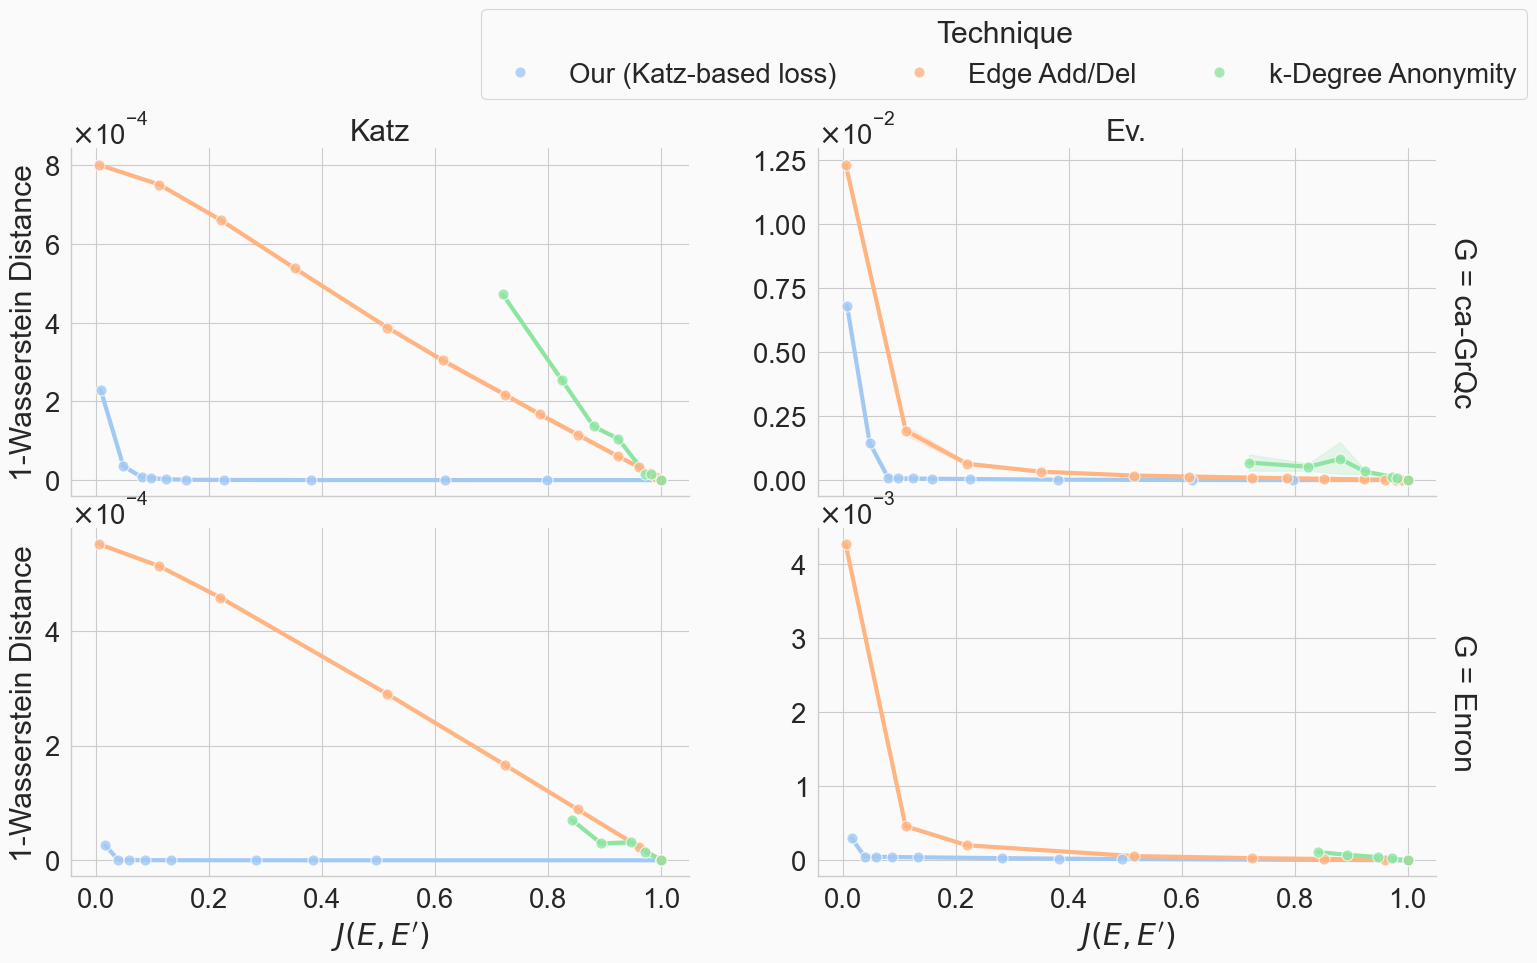

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def append_rows(samples, graph_name, method_names):
    for entry in samples:
        for method_name, metrics in entry.items():

            new_row = {"full_method_name": method_name, "G":graph_name}

            for name in method_names:
                if name in method_name:
                    new_row["method_type"] = name

            for metric, value in metrics.items():
                if isinstance(value, dict):
                    new_row[metric] = value['Ga']
                else:
                    new_row[metric] = value

            flat_rows.append(new_row)

def append_origin_rows(flat_rows, graph_name):
    flat_rows.append({"Katz": 0, "Ev.":0, "LCC":0, "EJacc":1, "method_type": "Eager", "G": graph_name, "full_method_name":"None"})
    flat_rows.append({"Katz": 0, "Ev.":0, "LCC":0, "EJacc":1, "method_type": "Anonymity", "G":graph_name, "full_method_name":"None"})
    flat_rows.append({"Katz": 0, "Ev.":0, "LCC":0, "EJacc":1, "method_type": "Edge Add/Del", "G":graph_name, "full_method_name":"None"})


with open('cache/exp3_figure_enron_samples_data.pkl', 'rb') as f:
    enron_samples_data = pickle.load(f)

with open('cache/exp3_figure_ca_GRQC_samples_data.pkl', 'rb') as f:
    ca_GrQc_samples_data = pickle.load(f)

with open('cache/exp3_figure_polbooks_samples_data.pkl', 'rb') as f:
    polbooks_samples_data = pickle.load(f)

flat_rows = []
#append_rows(polbooks_samples_data, "Polbooks", method_names = ["Eager", "Anonymity", "Edge Add/Del"])
append_rows(ca_GrQc_samples_data, "ca-GrQc", method_names = ["Eager", "Anonymity", "Edge Add/Del"])
append_rows(enron_samples_data, "Enron", method_names = ["Eager", "Anonymity", "Edge Add/Del"])
append_origin_rows(flat_rows, "Enron")
append_origin_rows(flat_rows, "ca-GrQc")
#append_origin_rows(flat_rows, "Polbooks")

df = pd.DataFrame(flat_rows)
df['EJacc'] = df.groupby(['G', 'full_method_name'])['EJacc'].transform('mean')

df_melted = df.melt(id_vars=['EJacc', 'method_type', 'G'],
                    value_vars=['Katz', 'Ev.'],
                    var_name='Metric',
                    value_name='1-Wasserstein Distance')

df_melted['method_type'] = df_melted['method_type'].replace('Anonymity', 'k-Degree Anonymity')
df_melted['method_type'] = df_melted['method_type'].replace('Eager', 'Our (Katz-based loss)')

sns.set_theme(style="whitegrid", context='paper', palette='pastel', font_scale=2.25,rc={"axes.facecolor": (250/255, 250/255, 250/255)})

factor = 0.9
height = 5 * factor
width = 3 * factor
g = sns.FacetGrid(df_melted, row="G", col="Metric", hue='method_type', sharey=False, height=height, aspect=width/height, margin_titles=True, despine=True)
g.figure.patch.set_facecolor((250/255, 250/255, 250/255))

g.map(sns.lineplot, "EJacc", "1-Wasserstein Distance", linewidth = 3, alpha = 1, err_kws={"alpha":0.2}, errorbar=('ci', 95))
g.map(sns.lineplot, "EJacc", "1-Wasserstein Distance", marker="o", markersize=8, alpha=0.8, linewidth = 0, err_kws={"alpha":0})

g.set_axis_labels("$J(E,E')$", "1-Wasserstein Distance")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Technique', loc= 'upper center', bbox_to_anchor=(0.69, 1.1), ncol=3,frameon=True)
plt.tight_layout()

for ax in g.axes.flatten():
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

plt.savefig("Experiment_2_plot_slides.pdf", bbox_inches="tight")
plt.show()
